## Use case 2: hourly rates as a function of skills and other profile variables.  Regression on numeric predictors plus cluster categories provides a statistically significant but very weak model.

## Why?  Omitted variable bias: the most crucial variable missing for each freelancer is active time since joining Upwork.  Hourly rates should be correlated with experience on Upwork: more proven ability, better ability to negotiate with employers.

In [1]:
import copy
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, roc_curve, auc, log_loss
from keras.models import Sequential
from keras import initializers
from keras.layers import Dense
from keras import optimizers
from kmodes.kmodes import KModes

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.concat([pd.read_csv(f) for f in glob.glob('./data/*')], ignore_index = True)

In [3]:
df = df.drop(['Unnamed: 0'], axis=1)

In [4]:
df.shape

(4950, 10)

In [5]:
df.head(50)

,bio,earned,edu,exp,headline,hours,jobs,rate,skills,tests
0,Google Adwords & Bing Ads Certified MBA market...,$200k+,3.0,8.0,"Marketing, Strategic Mgmt/Writer/SEO, SEM/Mark...","10,654",40,$45.00,"['Strategic Planning', 'Business Analysis', 'A...",9.0
1,I have been transcribing for more than 7 years...,$10k+,2.0,1.0,Transcriptionist,"1,043",60,$12.00,"['Transcription', 'Medical Transcription']",2.0
2,"Throughout my undergraduate years, I was a res...",$60k+,1.0,3.0,"Transcription (98WPM), Virtual Assistant","2,840",254,$15.00,"['Biology', 'English', 'Transcription', 'Virtu...",4.0
3,As a digital marketing professional with a foc...,$30k+,2.0,2.0,Full-Stack Digital Marketer | Facebook Ads Spe...,673,21,$75.00,"['Facebook Marketing', 'Inbound Marketing', 'M...",4.0
4,WordPress Development + Theme Customization + ...,$40k+,NaN,1.0,Turn-Key Responsive Website Design & Development,625,131,$45.00,"['WordPress', 'Woocommerce', 'Website Developm...",1.0
5,Raising money as a startup is hard work! The a...,$100k+,1.0,5.0,"Startup Specialist, Pitch Decks, Business Plan...",655,32,$150.00,"['Startup Consulting', 'Business Modeling', 'B...",1.0
6,Hire me to make sure that your business runs s...,$10k+,2.0,4.0,Tech Savvy Assistant for Busy Entrepreneur,434,34,$27.00,"['HTML', 'Customer Service', 'English', 'WordP...",4.0
7,I am a medical student at Northwestern Univers...,$10k+,2.0,2.0,Medical Writer and Researcher,347,13,$50.00,"['Customer Support', 'Medical Writing', 'Micro...",1.0
8,"My expertise in writing, editing, and designin...",$20k+,3.0,3.0,"Writer, Editor, and Instructional Designer",587,118,$37.50,"['Academic Writing', 'Copyediting', 'Editing',...",6.0
9,"👋 Hi, I'm Brandon! Top-Rated Wix Designer & De...",$40k+,1.0,1.0,WIX PROFESSIONAL: Expert Wix Website Designer ...,241,162,$50.00,"['WiX', 'Web Design', 'Website Development', '...",26.0


In [6]:
df = df.drop_duplicates()

In [7]:
df.shape

(4262, 10)

In [8]:
df.dtypes

bio          object
earned       object
edu         float64
exp         float64
headline     object
hours        object
jobs         object
rate         object
skills       object
tests       float64
dtype: object

In [9]:
df.isna().sum()

bio           17
earned      1525
edu          256
exp          796
headline      24
hours       1523
jobs        1494
rate           2
skills        70
tests       2017
dtype: int64

In [10]:
df = df[df.rate.notna()]

In [11]:
df.shape

(4260, 10)

In [12]:
df['skills'] = df['skills'].fillna('[]')

In [13]:
df['headline'] = df['headline'].fillna('')

In [14]:
df['bio'] = df['bio'].fillna('')

In [15]:
# sometimes hours and jobs will be zero but earned will be a positive number.
# the below will allow one to check the earned column to see whether a freelancer has worked or not
df = df.fillna('0')

In [16]:
df['rate'] = df['rate'].map(lambda string: float(''.join([c for c in string if c.isdigit()]))/100)

In [17]:
df['hours'] = df['hours'].map(lambda h: int(''.join([c for c in str(h) if c.isdigit()])))

In [18]:
df['jobs'] = df['jobs'].map(lambda j: int(''.join([c for c in str(j) if c.isdigit()])))

In [19]:
df['exp'] = df['exp'].map(lambda e: int(e))

In [20]:
df['edu'] = df['edu'].map(lambda e: int(e))

In [21]:
df['tests'] = df['tests'].map(lambda t: int(t))

In [22]:
df['skills'] = df['skills'].map(lambda sk_string: sk_string.replace('[', ""))

In [23]:
df['skills'] = df['skills'].map(lambda sk_string: sk_string.replace(']', ""))

In [24]:
df['skills'] = df['skills'].map(lambda sk_string: sk_string.replace("'", ""))

In [25]:
df['skills'] = df['skills'].map(lambda sk_string: sk_string.replace('"', ''))

In [26]:
df['skills'] = df['skills'].map(lambda sk_string: sk_string.split(", "))

In [27]:
# ternary operator
df['skills'] = df['skills'].map(lambda sk_list: (sk_list, [])[sk_list == ['']])

In [28]:
df.dtypes

bio          object
earned       object
edu           int64
exp           int64
headline     object
hours         int64
jobs          int64
rate        float64
skills       object
tests         int64
dtype: object

In [29]:
len(df)

4260

In [30]:
nn = 0
for i in range(len(df)):
    nn += (type(df['skills'].iloc[55]) == list)
nn

4260

In [31]:
# df = df[df.rate < 200]

In [32]:
df = df[df['earned'] != '0']

In [33]:
df.shape

(2735, 10)

In [34]:
df = df.reset_index(drop = True)

In [35]:
y = df.rate

In [36]:
std = np.std(y)
round(std, 3)

38.606

In [37]:
meany = np.mean(y)
round(meany, 3)

47.207

### Hourly rate by skill:

In [38]:
skills_df = df['skills'].str.join('|').str.get_dummies()

In [39]:
skills_df.shape

(2735, 1888)

In [40]:
for i in range(10):
    print(sum(skills_df.iloc[i, :]))

8
2
10
5
6
3
10
7
10
10


In [41]:
for i in range(10):
    print(len(df.iloc[i, 8]))

8
2
10
5
6
3
10
7
10
10


In [42]:
rate = copy.deepcopy(df.rate)

In [43]:
rate.head()

0    45.0
1    12.0
2    15.0
3    75.0
4    45.0
Name: rate, dtype: float64

In [44]:
df.head()

,bio,earned,edu,exp,headline,hours,jobs,rate,skills,tests
0,Google Adwords & Bing Ads Certified MBA market...,$200k+,3,8,"Marketing, Strategic Mgmt/Writer/SEO, SEM/Mark...",10654,40,45.0,"[Strategic Planning, Business Analysis, Advert...",9
1,I have been transcribing for more than 7 years...,$10k+,2,1,Transcriptionist,1043,60,12.0,"[Transcription, Medical Transcription]",2
2,"Throughout my undergraduate years, I was a res...",$60k+,1,3,"Transcription (98WPM), Virtual Assistant",2840,254,15.0,"[Biology, English, Transcription, Virtual Assi...",4
3,As a digital marketing professional with a foc...,$30k+,2,2,Full-Stack Digital Marketer | Facebook Ads Spe...,673,21,75.0,"[Facebook Marketing, Inbound Marketing, Market...",4
4,WordPress Development + Theme Customization + ...,$40k+,0,1,Turn-Key Responsive Website Design & Development,625,131,45.0,"[WordPress, Woocommerce, Website Development, ...",1


In [45]:
combined = pd.concat([skills_df, rate], axis = 1, sort = False)

In [46]:
combined.head()

,.NET Core,.NET Framework,.NET Remoting,2D Animation,2D Design,3D Animation,3D Design,3D Modeling,3D Printing,3D Rendering,...,iPhone App Development,iPhone UI Design,insightly,jQuery,jQuery UI,libGDX,logstash,phpMyAdmin,soapUI,rate
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,45.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,75.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,45.0


In [47]:
for i in range(10):
    print(sum(combined.iloc[i, :-1]))

8.0
2.0
10.0
5.0
6.0
3.0
10.0
7.0
10.0
10.0


In [48]:
for i in range(10):
    print(combined.iloc[i, -1])

45.0
12.0
15.0
75.0
45.0
150.0
27.0
50.0
37.5
50.0


In [49]:
sd_list = []
for c in combined.columns[:-1]: 
    skill_dict = dict.fromkeys(['mean', 'std', 'skill'], [])
    comb_g = combined.groupby(c)
    group_rate = comb_g.get_group(1)['rate']
    skill_dict['g_r'] = group_rate
    skill_dict['mean'] = np.mean(group_rate)
    skill_dict['std'] = np.std(group_rate)
    skill_dict['skill'] = str(c)
    skill_dict['count'] = len(group_rate)
    sd_list.append(skill_dict)

In [50]:
skill_table = pd.DataFrame(sd_list)

In [51]:
skill_table.head(10)

,count,g_r,mean,skill,std
0,1,"2711 30.0 Name: rate, dtype: float64",30.000000,.NET Core,0.000000
1,29,208 200.00 264 150.00 325 65.00 3...,75.402069,.NET Framework,47.065003
2,1,"502 50.0 Name: rate, dtype: float64",50.000000,.NET Remoting,0.000000
3,14,31 37.5 63 27.0 656 45.0 751 ...,46.535714,2D Animation,11.760200
4,17,492 38.0 568 55.0 633 12.0 650 ...,34.029412,2D Design,15.635998
5,8,31 37.5 173 32.0 967 25.0 1118 ...,38.000000,3D Animation,10.773231
6,17,427 30.00 547 25.00 568 55.00 769 ...,38.514706,3D Design,18.010306
7,28,15 25.0 31 37.5 173 32.0 249 ...,44.785714,3D Modeling,17.342366
8,14,142 70.00 215 13.00 502 50.00 644 ...,46.375000,3D Printing,21.383561
9,20,97 100.0 121 20.0 173 32.0 568 ...,48.125000,3D Rendering,23.279752


In [52]:
skill_table = skill_table.sort_values(by = ['mean'], ascending = False)
skill_table = skill_table.reset_index(drop = True)

In [53]:
skill_tab = skill_table[skill_table['count'] > 10]
skill_tab = skill_tab.reset_index(drop = True)

In [54]:
ds = skill_table[skill_table['skill'] == 'Data Science']

In [55]:
ds

,count,g_r,mean,skill,std
332,21,10 100.00 54 150.00 197 75.00 2...,74.428095,Data Science,35.115206


In [56]:
skill_tab.loc[0:40, skill_tab.columns != 'g_r']

,count,mean,skill,std
0,26,105.346154,Startup Consulting,55.338776
1,19,90.877895,Ruby,59.125761
2,21,90.500000,Management Consulting,53.494548
3,11,87.272727,Financial Writing,26.744892
4,16,86.750000,Business Coaching,55.793985
5,16,86.031250,DevOps,30.397995
6,12,83.000000,Organizational Behavior,95.311769
7,11,82.159091,Docker,28.900746
8,20,81.950000,Travel Writing,210.969468
9,11,81.409091,Rapid Prototyping,48.681160


### Clustering

In [58]:
km = KModes(n_clusters=15, init='Huang', n_init=6, verbose=1)
clusters = km.fit_predict(skills_df)
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 350, cost: 20256.0
Run 1, iteration: 2/100, moves: 72, cost: 20256.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 153, cost: 20224.0
Run 2, iteration: 2/100, moves: 99, cost: 20145.0
Run 2, iteration: 3/100, moves: 9, cost: 20145.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 132, cost: 20179.0
Run 3, iteration: 2/100, moves: 0, cost: 20179.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 384, cost: 20127.0
Run 4, iteration: 2/100, moves: 59, cost: 20127.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 377, cost: 20042.0
Run 5, iteration: 2/100, moves: 25, cost: 20042.0
Init: initializing centroids
Init: initializing

In [59]:
kmodes = km.cluster_centroids_
shape = kmodes.shape

In [60]:
for i in range(shape[0]):
    if sum(kmodes[i,:]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no-skills cluster")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i,:]
        for j in skills_df.columns[np.nonzero(cent)]:
            print(j)


cluster 0: 
Microsoft PowerPoint

cluster 1: 
no-skills cluster

cluster 2: 
Legal Transcription
Transcription

cluster 3: 
English

cluster 4: 
Article Writing
Blog Writing
Editing

cluster 5: 
Copywriting

cluster 6: 
WordPress

cluster 7: 
Editing
Proofreading
Writing

cluster 8: 
Administrate
Social Media Marketing

cluster 9: 
Content Writing
Microsoft Office
WordPress

cluster 10: 
Customer Service

cluster 11: 
Copyediting
Copywriting

cluster 12: 
Project Management

cluster 13: 
Microsoft Excel
Microsoft PowerPoint
Microsoft Word

cluster 14: 
Adobe Illustrator
Adobe InDesign
Adobe Photoshop


In [61]:
clust_assigned = km.predict(skills_df)

In [62]:
unique, counts = np.unique(clust_assigned, return_counts=True)
dict(zip(unique, counts))

{0: 51,
 1: 1354,
 2: 1,
 3: 81,
 4: 129,
 5: 112,
 6: 347,
 7: 80,
 8: 2,
 9: 4,
 10: 150,
 11: 74,
 12: 98,
 13: 122,
 14: 130}

In [ ]:
restrict = copy.deepcopy(skills_df)
for name in restrict.columns:
    if sum(restrict[name]) < 50:
        restrict = restrict.drop([name], axis = 1)

In [ ]:
restrict.head()

In [ ]:
km2 = KModes(n_clusters=15, init='Huang', n_init=11, verbose=1)
clusters = km2.fit_predict(restrict)
print(km2.cluster_centroids_)

In [ ]:
kmodes2 = km2.cluster_centroids_
shape2 = kmodes2.shape

In [ ]:
for i in range(shape2[0]):
    if sum(kmodes2[i,:]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no-skills cluster")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes2[i,:]
        for j in restrict.columns[np.nonzero(cent)]:
            print(j)

In [ ]:
clust_assigned2 = km2.predict(restrict)

In [ ]:
unique2, counts2 = np.unique(clust_assigned2, return_counts=True)
dict(zip(unique2, counts2))

### Cluster Boxplot

In [63]:
df.shape

(2735, 10)

In [64]:
for_box = np.stack((clust_assigned, y), axis = 1)

In [65]:
box_df = pd.DataFrame(for_box)

In [66]:
box_df.columns = ['cluster', 'rate']

(0, 200)

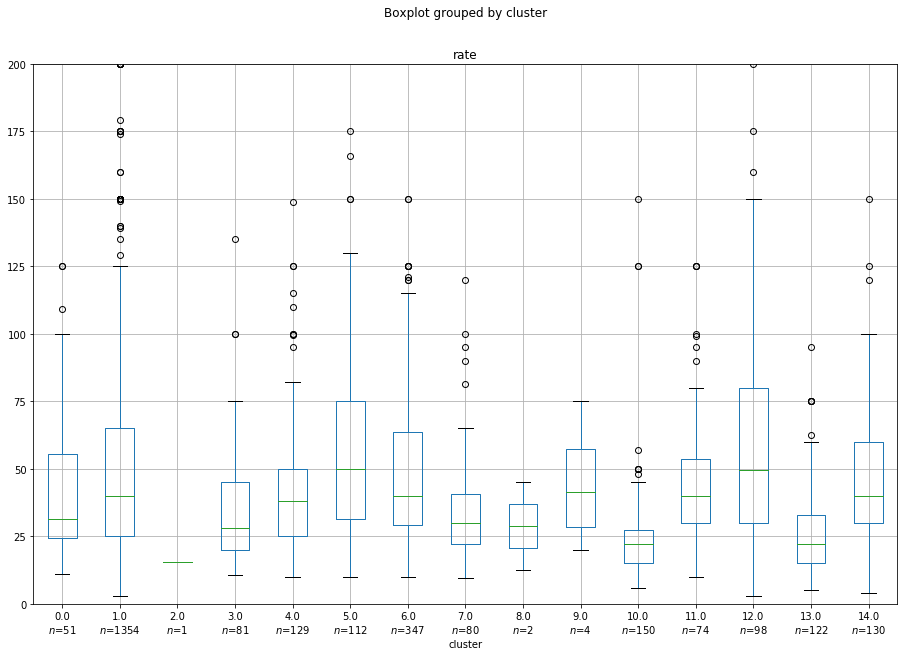

In [67]:
dfg = box_df.groupby('cluster')
counts = [len(v) for k, v in dfg]
total = float(sum(counts))
cases = len(counts)
widths = [c/total for c in counts]  
cax = box_df.boxplot(column='rate', by='cluster', figsize=(15,10))
cax.set_xticklabels(['%s\n$n$=%d'%(k, len(v)) for k, v in dfg])
cax.set_ylim([0,200])

### Predicting with cluster means

In [68]:
box_means = dfg.mean()

In [69]:
df.shape

(2735, 10)

In [70]:
y_and_cluster_means = pd.merge(box_means, box_df, how='inner', on='cluster', left_on=None, right_on=None,
         left_index=False, right_index=True, sort=False,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

In [71]:
y_and_cluster_means.head()

,rate_x,rate_y
cluster,,
0.0,43.368627,21.5
0.0,43.368627,58.0
0.0,43.368627,125.0
0.0,43.368627,50.0
0.0,43.368627,70.0


In [72]:
r2_score(y_and_cluster_means.rate_y, y_and_cluster_means.rate_x)

0.05059709992647976

In [73]:
std - np.sqrt(mean_squared_error(y_and_cluster_means.rate_y, y_and_cluster_means.rate_x))

0.9893490214071363

### Making the predictor matrix (more feature engineering)

In [74]:
X = df.drop(['rate'], axis = 1)

In [75]:
X.skills = X.skills.map(lambda li: len(li))

In [76]:
fn = lambda row: len(row.headline) # define a function for the new column
X = X.assign(head_len = X.apply(fn, axis=1).values)

In [77]:
fn = lambda row: len(row.headline) // len(row.headline.split(' '))
X = X.assign(hd_wrd_len = X.apply(fn, axis=1).values)

In [78]:
fn = lambda row: len(row.bio)
X = X.assign(bio_len = X.apply(fn, axis=1).values)

In [79]:
fn = lambda row: len(row.bio) // len(row.bio.split(' ')) 
X = X.assign(bio_wrd_len = X.apply(fn, axis=1).values)

In [80]:
X.head()

,bio,earned,edu,exp,headline,hours,jobs,skills,tests,head_len,hd_wrd_len,bio_len,bio_wrd_len
0,Google Adwords & Bing Ads Certified MBA market...,$200k+,3,8,"Marketing, Strategic Mgmt/Writer/SEO, SEM/Mark...",10654,40,8,9,66,11,2608,6
1,I have been transcribing for more than 7 years...,$10k+,2,1,Transcriptionist,1043,60,2,2,16,16,305,6
2,"Throughout my undergraduate years, I was a res...",$60k+,1,3,"Transcription (98WPM), Virtual Assistant",2840,254,10,4,40,10,430,6
3,As a digital marketing professional with a foc...,$30k+,2,2,Full-Stack Digital Marketer | Facebook Ads Spe...,673,21,5,4,53,7,2050,6
4,WordPress Development + Theme Customization + ...,$40k+,0,1,Turn-Key Responsive Website Design & Development,625,131,6,1,48,8,664,7


In [81]:
X = X.drop(['bio', 'earned', 'headline',], axis = 1)

In [82]:
X.head()

,edu,exp,hours,jobs,skills,tests,head_len,hd_wrd_len,bio_len,bio_wrd_len
0,3,8,10654,40,8,9,66,11,2608,6
1,2,1,1043,60,2,2,16,16,305,6
2,1,3,2840,254,10,4,40,10,430,6
3,2,2,673,21,5,4,53,7,2050,6
4,0,1,625,131,6,1,48,8,664,7


In [83]:
X.dtypes

edu            int64
exp            int64
hours          int64
jobs           int64
skills         int64
tests          int64
head_len       int64
hd_wrd_len     int64
bio_len        int64
bio_wrd_len    int64
dtype: object

In [84]:
clust = pd.Series(clust_assigned)

In [85]:
clust.shape

(2735,)

In [86]:
# clust = clust.reset_index(drop = True)

In [87]:
# X = X.reset_index(drop = True)

In [88]:
result = pd.concat([X, clust], axis = 1, sort = False)

In [89]:
result.rename(columns={0: 'cluster'}, inplace=True)

In [90]:
result.head()

,edu,exp,hours,jobs,skills,tests,head_len,hd_wrd_len,bio_len,bio_wrd_len,cluster
0,3,8,10654,40,8,9,66,11,2608,6,1
1,2,1,1043,60,2,2,16,16,305,6,1
2,1,3,2840,254,10,4,40,10,430,6,3
3,2,2,673,21,5,4,53,7,2050,6,5
4,0,1,625,131,6,1,48,8,664,7,6


In [91]:
result_dum = pd.get_dummies(result, columns = ['cluster'])

In [92]:
result_dum.head()

,edu,exp,hours,jobs,skills,tests,head_len,hd_wrd_len,bio_len,bio_wrd_len,...,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14
0,3,8,10654,40,8,9,66,11,2608,6,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1043,60,2,2,16,16,305,6,...,0,0,0,0,0,0,0,0,0,0
2,1,3,2840,254,10,4,40,10,430,6,...,0,0,0,0,0,0,0,0,0,0
3,2,2,673,21,5,4,53,7,2050,6,...,1,0,0,0,0,0,0,0,0,0
4,0,1,625,131,6,1,48,8,664,7,...,0,1,0,0,0,0,0,0,0,0


In [93]:
result_dum.shape

(2735, 25)

In [94]:
result_dum.isna().sum()

edu            0
exp            0
hours          0
jobs           0
skills         0
tests          0
head_len       0
hd_wrd_len     0
bio_len        0
bio_wrd_len    0
cluster_0      0
cluster_1      0
cluster_2      0
cluster_3      0
cluster_4      0
cluster_5      0
cluster_6      0
cluster_7      0
cluster_8      0
cluster_9      0
cluster_10     0
cluster_11     0
cluster_12     0
cluster_13     0
cluster_14     0
dtype: int64

### Normalizing the predictor variables

In [95]:
norm_x = scale(X)

In [96]:
pca = PCA()
nx = pca.fit_transform(norm_x)

In [97]:
pca.explained_variance_

array([1.81303002, 1.22582857, 1.10477938, 1.01006683, 0.98951616,
       0.88813037, 0.79751108, 0.76819701, 0.73194161, 0.67465662])

In [98]:
nx = pd.DataFrame(nx)

In [99]:
nx.head()

,0,1,2,3,4,5,6,7,8,9
0,4.115624,2.632597,-0.101756,1.316947,-1.653452,0.231310,1.627862,-0.594969,0.095583,0.396956
1,-1.726502,1.271565,2.402553,1.452574,0.502881,-1.715443,0.858174,0.456867,0.444865,0.489602
2,0.136515,0.797284,0.162744,0.474670,0.298927,0.099244,-1.225123,-0.269011,-0.047908,0.241261
3,0.408673,-0.119873,-0.698414,0.013913,-0.101541,-0.898067,1.534765,0.814199,-0.054682,0.056092
4,-1.341179,-0.293220,-0.635489,0.966307,1.205188,0.312058,-0.050191,0.097328,-0.576039,-0.606702


In [100]:
norm_result = pd.concat([nx, clust], axis = 1, sort = False)

In [101]:
norm_result.columns = result.columns

In [102]:
norm_result.head()

,edu,exp,hours,jobs,skills,tests,head_len,hd_wrd_len,bio_len,bio_wrd_len,cluster
0,4.115624,2.632597,-0.101756,1.316947,-1.653452,0.231310,1.627862,-0.594969,0.095583,0.396956,1
1,-1.726502,1.271565,2.402553,1.452574,0.502881,-1.715443,0.858174,0.456867,0.444865,0.489602,1
2,0.136515,0.797284,0.162744,0.474670,0.298927,0.099244,-1.225123,-0.269011,-0.047908,0.241261,3
3,0.408673,-0.119873,-0.698414,0.013913,-0.101541,-0.898067,1.534765,0.814199,-0.054682,0.056092,5
4,-1.341179,-0.293220,-0.635489,0.966307,1.205188,0.312058,-0.050191,0.097328,-0.576039,-0.606702,6


In [103]:
norm_dum = pd.get_dummies(norm_result, columns = ['cluster'])

In [104]:
norm_dum.head()

,edu,exp,hours,jobs,skills,tests,head_len,hd_wrd_len,bio_len,bio_wrd_len,...,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14
0,4.115624,2.632597,-0.101756,1.316947,-1.653452,0.231310,1.627862,-0.594969,0.095583,0.396956,...,0,0,0,0,0,0,0,0,0,0
1,-1.726502,1.271565,2.402553,1.452574,0.502881,-1.715443,0.858174,0.456867,0.444865,0.489602,...,0,0,0,0,0,0,0,0,0,0
2,0.136515,0.797284,0.162744,0.474670,0.298927,0.099244,-1.225123,-0.269011,-0.047908,0.241261,...,0,0,0,0,0,0,0,0,0,0
3,0.408673,-0.119873,-0.698414,0.013913,-0.101541,-0.898067,1.534765,0.814199,-0.054682,0.056092,...,1,0,0,0,0,0,0,0,0,0
4,-1.341179,-0.293220,-0.635489,0.966307,1.205188,0.312058,-0.050191,0.097328,-0.576039,-0.606702,...,0,1,0,0,0,0,0,0,0,0


### Running the models

In [105]:
cv = 4

In [106]:
tr = DecisionTreeRegressor(max_depth = 3)
trmodel = tr.fit(result_dum, y)

In [107]:
trmodel.score(result_dum, y)

0.10803556074130494

In [108]:
np.mean(cross_val_score(trmodel, result_dum, y, scoring = 'r2', cv = cv))

0.04781576980700783

In [109]:
std - np.sqrt(-1*np.mean(cross_val_score(trmodel, result_dum, y, scoring = 'neg_mean_squared_error', cv = cv)))

0.5048196805286409

In [110]:
ntr = DecisionTreeRegressor(max_depth = 3)
ntrmodel = tr.fit(norm_dum, y)

In [111]:
ntrmodel.score(norm_dum, y)

0.10172459386353096

In [112]:
np.mean(cross_val_score(ntrmodel, norm_dum, y, scoring = 'r2', cv = cv))

-0.015294814036275528

In [113]:
std - np.sqrt(-1*np.mean(cross_val_score(ntrmodel, norm_dum, y, scoring = 'neg_mean_squared_error', cv = cv)))

-0.28732909694350894

In [114]:
rf = RandomForestRegressor(n_estimators = 500, max_depth = 5)
rfmodel = rf.fit(result_dum, y)

In [115]:
rfmodel.score(result_dum, y)

0.23206180588999015

In [116]:
np.mean(cross_val_score(rfmodel, result_dum, y, scoring = 'r2', cv = cv))

0.088851054297479

In [117]:
std - np.sqrt(-1*np.mean(cross_val_score(rfmodel, result_dum, y, scoring = 'neg_mean_squared_error', cv = cv)))

1.69895907113699

In [118]:
nrf = RandomForestRegressor(n_estimators = 500, max_depth = 5)
nrfmodel = rf.fit(norm_dum, y)

In [119]:
nrfmodel.score(norm_dum, y)

0.34710111524986564

In [120]:
np.mean(cross_val_score(nrfmodel, norm_dum, y, scoring = 'r2', cv = cv))

0.06538911767601882

In [121]:
std - np.sqrt(-1*np.mean(cross_val_score(nrfmodel, norm_dum, y, scoring = 'neg_mean_squared_error', cv = cv)))

1.247668390105325

[ 1  0  7  9  8  2  4  6 20  3 23  5 11 22 15 13 16 17 14 21 10 24 19 18
 12]


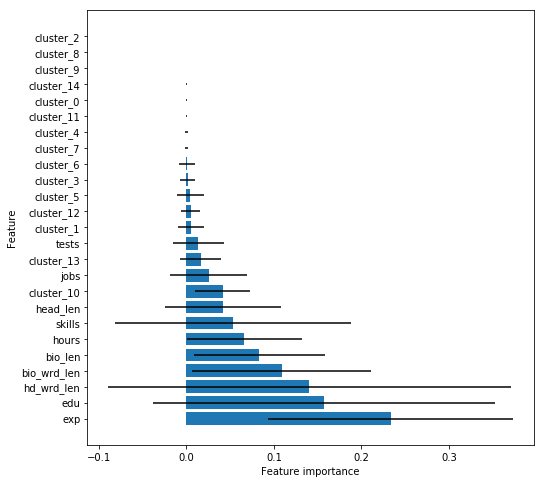

In [123]:
def plot_feature_importances(model):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    print(indices)
    n_features = norm_dum.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), importances[indices], xerr=std[indices], align='center') 
    plt.yticks(np.arange(n_features), norm_dum.columns.values[indices]) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(rfmodel)

In [124]:
ada = AdaBoostRegressor(n_estimators = 1000, learning_rate = 0.01)
adamodel = ada.fit(result_dum, y)

In [125]:
adamodel.score(result_dum, y)

0.24280803816577867

In [126]:
np.mean(cross_val_score(adamodel, result_dum, y, scoring = 'r2', cv = cv))

-0.019779170070785668

In [127]:
std - np.sqrt(-1*np.mean(cross_val_score(adamodel, result_dum, y, scoring = 'neg_mean_squared_error', cv = cv)))

-0.26211774685110356

In [128]:
nada = AdaBoostRegressor(n_estimators = 1000, learning_rate = 0.01)
nadamodel = nada.fit(norm_dum, y)

In [129]:
nadamodel.score(norm_dum, y)

0.3020896285392777

In [130]:
np.mean(cross_val_score(nadamodel, norm_dum, y, scoring = 'r2', cv = cv))

-0.022022555433960145

In [131]:
std - np.sqrt(-1*np.mean(cross_val_score(nadamodel, norm_dum, y, scoring = 'neg_mean_squared_error', cv = cv)))

-0.41947706023742626

In [132]:
parameters = {'metric':('jaccard', 'matching', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 
                        'sokalmichener', 'sokalsneath'), 'n_neighbors':[2, 10, 25, 50, 100]}

In [133]:
neigh = KNeighborsRegressor()
reg = GridSearchCV(neigh, parameters, cv = cv, scoring = 'neg_mean_squared_error')
reg.fit(result_dum, y) 

GridSearchCV(cv=4, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'metric': ('jaccard', 'matching', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath'), 'n_neighbors': [2, 10, 25, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [134]:
bestknn = reg.best_params_

In [135]:
bestknn

{'metric': 'kulsinski', 'n_neighbors': 50}

In [136]:
knnbest = KNeighborsRegressor(n_neighbors = bestknn['n_neighbors'], metric = bestknn['metric'])
std - np.sqrt(-1*np.mean(cross_val_score(knnbest, result_dum, y, scoring = 'neg_mean_squared_error', cv = cv)))

0.6994420212102028

In [137]:
np.mean(cross_val_score(knnbest, result_dum, y, scoring = 'r2', cv = cv))

0.03684685450233899

In [138]:
nneigh = KNeighborsRegressor()
nreg = GridSearchCV(nneigh, parameters, cv = cv, scoring = 'neg_mean_squared_error')
nreg.fit(norm_dum, y) 

GridSearchCV(cv=4, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'metric': ('jaccard', 'matching', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath'), 'n_neighbors': [2, 10, 25, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [139]:
nbestknn = nreg.best_params_

In [140]:
nbestknn

{'metric': 'jaccard', 'n_neighbors': 100}

In [141]:
nknnbest = KNeighborsRegressor(n_neighbors = nbestknn['n_neighbors'], metric = nbestknn['metric'])
std - np.sqrt(-1*np.mean(cross_val_score(nknnbest, norm_dum, y, scoring = 'neg_mean_squared_error', cv = cv)))

0.4833598775676933

In [142]:
np.mean(cross_val_score(knnbest, result_dum, y, scoring = 'r2', cv = cv))

0.03684685450233899

In [143]:
ridgeReg = Ridge(alpha=100)

In [144]:
ridgeReg.fit(result_dum, y)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [145]:
max(ridgeReg.coef_) - min(ridgeReg.coef_)

17.10345545572791

In [146]:
coef = pd.Series(ridgeReg.coef_, result_dum.columns).sort_values()

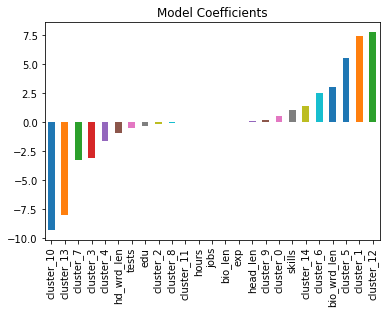

In [147]:
coef.plot(kind='bar', title='Model Coefficients')

In [148]:
np.mean(cross_val_score(Ridge(alpha=100), result_dum, y, scoring = 'r2', cv = cv))

0.04527124751009262

In [149]:
std - np.sqrt(-1 * np.mean(cross_val_score(Ridge(alpha=100), result_dum, y, scoring = 'neg_mean_squared_error', cv = cv)))

1.0823900322364253

In [150]:
nridgeReg = Ridge(alpha=100)

In [151]:
nridgeReg.fit(norm_dum, y)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [152]:
max(nridgeReg.coef_) - min(nridgeReg.coef_)

17.174978397678622

In [153]:
ncoef = pd.Series(nridgeReg.coef_, norm_dum.columns).sort_values()

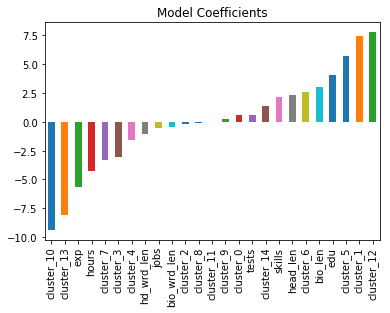

In [154]:
ncoef.plot(kind='bar', title='Model Coefficients')

In [155]:
np.mean(cross_val_score(Ridge(alpha=100), norm_dum, y, scoring = 'r2', cv = cv))

0.0832580899802286

In [156]:
std - np.sqrt(-1 * np.mean(cross_val_score(Ridge(alpha=100), norm_dum, y, scoring = 'neg_mean_squared_error', cv = cv)))

1.6593104593371066

In [157]:
lin = LinearRegression()
linmodel = lin.fit(result_dum, y)

In [158]:
linmodel.score(result_dum,y)

0.12036221299058092

In [159]:
max(linmodel.coef_) - min(linmodel.coef_)

31.471044452132098

In [160]:
coef2 = pd.Series(linmodel.coef_, result_dum.columns).sort_values()

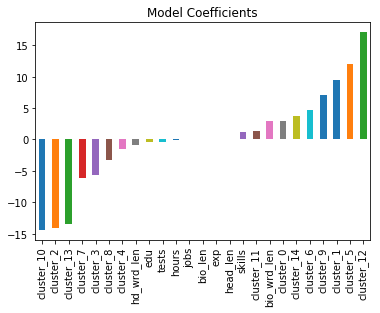

In [161]:
coef2.plot(kind='bar', title='Model Coefficients')

In [162]:
linmodel.intercept_

11.27608708491988

In [163]:
np.mean(cross_val_score(LinearRegression(), result_dum, y, scoring = 'r2', cv = cv))

0.036703212570561805

In [164]:
std - np.sqrt(-1 * np.mean(cross_val_score(LinearRegression(), result_dum, y, scoring = 'neg_mean_squared_error', cv = cv)))

0.9875918375949908

In [165]:
nlin = LinearRegression()
nlinmodel = nlin.fit(norm_dum, y)

In [166]:
nlinmodel.score(norm_dum,y)

0.12036221299058092

In [167]:
max(nlinmodel.coef_) - min(nlinmodel.coef_)

31.47104445213212

In [168]:
coef3 = pd.Series(nlinmodel.coef_, norm_dum.columns).sort_values()

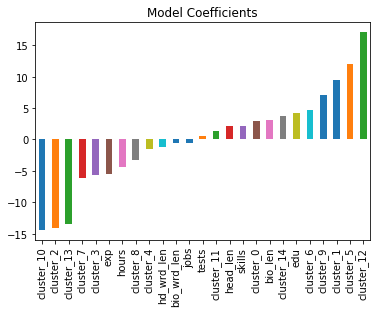

In [169]:
coef3.plot(kind='bar', title='Model Coefficients')

In [170]:
nlinmodel.intercept_

42.353554465108004

In [171]:
np.mean(cross_val_score(LinearRegression(), norm_dum, y, scoring = 'r2', cv = cv))

0.0367032125705595

In [172]:
std - np.sqrt(-1 * np.mean(cross_val_score(LinearRegression(), norm_dum, y, scoring = 'neg_mean_squared_error', cv = cv)))

0.9875918375949624

In [252]:
XX = np.array(copy.deepcopy(result_dum))

In [253]:
XXT = XX.T

In [254]:
prod = XXT @ XX

In [255]:
prod.shape

(25, 25)

In [256]:
inv = np.linalg.inv(prod)

In [257]:
inv.shape

(25, 25)

In [258]:
triple_X = inv @ XXT

In [259]:
type(triple_X)

numpy.ndarray

In [260]:
z = np.array(y)

In [261]:
z.shape

(2735,)

In [262]:
theta = triple_X @ z

In [263]:
type(XX)

numpy.ndarray

In [264]:
preds = [theta @ XX[i,:] for i in range(len(z))]

In [265]:
err = [(y[i] - preds[i])for i in range(len(y))]

In [266]:
RMSE = (sum([e**2 for e in err])/len(y))**0.5

In [267]:
std - RMSE

2.397806597494622

In [268]:
results = sm.OLS(y, XX).fit()

In [269]:
print(list(zip(list(result_dum.columns),list(theta))))

[('edu', -0.4478596020367455), ('exp', 0.07403222422227351), ('hours', -0.0007702896857082989), ('jobs', 0.002276699986293663), ('skills', 1.139648552410771), ('tests', -0.4471919527318311), ('head_len', 0.09280728543673963), ('hd_wrd_len', -0.8552452673691775), ('bio_len', 0.008970697112424573), ('bio_wrd_len', 2.9485234602855117), ('cluster_0', 14.266478509205518), ('cluster_1', 20.75569910728725), ('cluster_2', -2.793942215454102), ('cluster_3', 5.648107036878207), ('cluster_4', 9.723574200054472), ('cluster_5', 23.36633579900385), ('cluster_6', 15.898519386920789), ('cluster_7', 5.195835866328224), ('cluster_8', 8.091672165317608), ('cluster_9', 18.283092307877578), ('cluster_10', -3.099198619274469), ('cluster_11', 12.56616097857205), ('cluster_12', 28.371845832857456), ('cluster_13', -2.2017650298693505), ('cluster_14', 15.06889094808718)]


In [270]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     15.45
Date:                Thu, 04 Oct 2018   Prob (F-statistic):           2.06e-59
Time:                        10:23:28   Log-Likelihood:                -13697.
No. Observations:                2735   AIC:                         2.744e+04
Df Residuals:                    2710   BIC:                         2.759e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4479      0.884     -0.507      0.6

In [186]:
model = Sequential()
model.add(Dense(8, input_dim=25, activation='relu'))
model.add(Dense(1, activation = 'linear'))
model.compile(optimizer= "Adam", loss='mse', metrics=['mse'])
hist = model.fit(norm_dum, y, batch_size=10, 
                 epochs=100, verbose = True)

Epoch 1/100
2735/2735 [==============================] - 1s 263us/step - loss: 3589.4768 - mean_squared_error: 3589.4768
Epoch 2/100
2735/2735 [==============================] - 0s 141us/step - loss: 3302.5924 - mean_squared_error: 3302.5924
Epoch 3/100
2735/2735 [==============================] - 0s 178us/step - loss: 2836.2721 - mean_squared_error: 2836.2721
Epoch 4/100
2735/2735 [==============================] - 0s 175us/step - loss: 2320.4502 - mean_squared_error: 2320.4502
Epoch 5/100
2735/2735 [==============================] - 1s 184us/step - loss: 1894.2913 - mean_squared_error: 1894.2913
Epoch 6/100
2735/2735 [==============================] - 0s 180us/step - loss: 1605.9888 - mean_squared_error: 1605.9888
Epoch 7/100
2735/2735 [==============================] - 0s 179us/step - loss: 1445.2445 - mean_squared_error: 1445.2445
Epoch 8/100
2735/2735 [==============================] - 0s 171us/step - loss: 1375.1827 - mean_squared_error: 1375.1827
Epoch 9/100
2735/2735 [=========

In [187]:
pred_nn = model.predict(norm_dum).reshape(-1)
RMSE = np.sqrt(np.mean((pred_nn - y)**2))
std - RMSE

2.656034824180182

In [200]:
kfold = KFold(n_splits=cv, shuffle=True, random_state=7)

In [201]:
norm_dum_copy = copy.deepcopy(norm_dum)

In [202]:
y_copy = copy.deepcopy(y)

In [208]:
cvscores = []
cvscores_RMS = []
nd_array = np.array(norm_dum)
y_array = np.array(y)

In [216]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot))

In [223]:
for train, test in kfold.split(nd_array, y_array):
    model = Sequential()
    model.add(Dense(8, input_dim=25, activation='relu'))
    model.add(Dense(8, input_dim=25, activation='relu'))
    model.add(Dense(1, activation = 'linear'))
    model.compile(optimizer= "Adam", loss = 'mse', metrics=[coeff_determination])
    hist = model.fit(nd_array, y_array, batch_size=10, 
                 epochs=10, verbose = 0)
    scores = model.evaluate(nd_array[test], y_array[test], verbose=0, batch_size = 10)
    print('{}: {}'.format(model.metrics_names[1], scores[1]))
    cvscores.append(scores[1])
print('{} +/- {}'.format(np.mean(cvscores), np.std(cvscores)))

coeff_determination: -0.21575003653241878
coeff_determination: -0.06175692597327874
coeff_determination: -0.06402998535256636
coeff_determination: -0.23206584066108937
-0.12833808310398553 +/- 0.0725528361087963


In [224]:
for train, test in kfold.split(nd_array, y_array):
    model = Sequential()
    model.add(Dense(8, input_dim=25, activation='relu'))
    model.add(Dense(8, input_dim=25, activation='relu'))
    model.add(Dense(1, activation = 'linear'))
    model.compile(optimizer= "Adam", loss = 'mse', metrics=['mse'])
    hist = model.fit(nd_array, y_array, batch_size=10, 
                 epochs=10, verbose = 0)
    scores = model.evaluate(nd_array[test], y_array[test], verbose=0, batch_size = 10)
    sc = np.sqrt(scores[1])
    print('{}: {}'.format(model.metrics_names[1], sc))
    cvscores_RMS.append(sc)
RMS = np.mean(cvscores_RMS)
print('{} +/- {}'.format(RMS, np.std(cvscores_RMS)))

mean_squared_error: 30.396831749027374
mean_squared_error: 31.363227711677215
mean_squared_error: 30.826090304628245
mean_squared_error: 49.05458292290028
35.636967936208286 +/- 7.864186597077554


In [222]:
std - RMS

2.8932876350128893